# Sensor Model Training Notebook (6-Feature Only)

Offline training for centrifugal pump maintenance prediction using **Polars + LightGBM**.

**Strict feature order** (must match inference):  
`[Temperature, Vibration, Pressure, Flow_Rate, RPM, Operational_Hours]`

- No rolling/lag/derived features — CSV columns only.
- Unified schema: `Pump_ID`, `Operational_Hours`, `Maintenance_Flag` + the 6 sensor columns.
- Saves `sensor_lgbm_model.txt` and `sensor_feature_columns.json` so inference uses the same order universally.

In [81]:
from __future__ import annotations

import json
import pickle
from pathlib import Path

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import shap
from sklearn.metrics import (
    accuracy_score,
    average_precision_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    precision_recall_curve,
    precision_score,
    recall_score,
    roc_auc_score,
    )

TARGET_COL = "Maintenance_Flag"
ASSET_COL = "Pump_ID"
TIME_COL = "Operational_Hours"
MAX_ROWS = 20_000

# Exact order for training and inference (do not reorder)
STRICT_FEATURE_ORDER = [
    "Temperature",
    "Vibration",
    "Pressure",
    "Flow_Rate",
    "RPM",
    "Operational_Hours",
]

possible_paths = [
    Path("data/raw/Large_Industrial_Pump_Maintenance_Dataset.csv"),
    Path("../data/raw/Large_Industrial_Pump_Maintenance_Dataset.csv"),
    Path("/Users/polisetty/Downloads/projects/Minimal Predictive Agent/data/raw/Large_Industrial_Pump_Maintenance_Dataset.csv"),
]
DATA_PATH = next((p for p in possible_paths if p.exists()), possible_paths[0])
DATA_PATH = DATA_PATH.resolve()
PROJECT_ROOT = DATA_PATH.parents[2] if len(DATA_PATH.parents) >= 3 else Path.cwd().resolve()

MODEL_DIR = PROJECT_ROOT / "app/models"
MODEL_OUTPUT = MODEL_DIR / "sensor_lgbm_model.txt"
FEATURES_OUTPUT = MODEL_DIR / "sensor_feature_columns.json"

RANDOM_STATE = 42

pl.Config.set_tbl_rows(8)
pl.Config.set_tbl_cols(20)
print("Using DATA_PATH:", DATA_PATH)
print("Project root:", PROJECT_ROOT)
print("Model output dir:", MODEL_DIR)

Using DATA_PATH: /Users/polisetty/Downloads/projects/Minimal Predictive Agent/data/raw/Large_Industrial_Pump_Maintenance_Dataset.csv
Project root: /Users/polisetty/Downloads/projects/Minimal Predictive Agent
Model output dir: /Users/polisetty/Downloads/projects/Minimal Predictive Agent/app/models


## 1) Set Up Notebook Environment
Reusable constants and helper functions are defined in subsequent cells.

In [82]:
def save_artifacts(model, feature_columns):
    MODEL_DIR.mkdir(parents=True, exist_ok=True)
    model.booster_.save_model(str(MODEL_OUTPUT)) if hasattr(model, 'booster_') else model.save_model(str(MODEL_OUTPUT))
    with FEATURES_OUTPUT.open("w", encoding="utf-8") as f:
        json.dump(feature_columns, f, indent=2)
    print("Saved:")
    print("-", MODEL_OUTPUT)
    print("-", FEATURES_OUTPUT)


In [83]:
def train_model(df_train: pl.DataFrame, feature_columns: list[str], target_col: str, random_state: int = 42):
    import lightgbm as lgb
    import numpy as np
    from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve
    from sklearn.model_selection import train_test_split

    n_train_rows = min(MAX_ROWS, df_train.height)
    train_df = (
        df_train
        .head(n_train_rows)
        .with_columns(pl.col(target_col).fill_null(0).cast(pl.Int8))
    )

    idx = np.arange(train_df.height)
    np.random.default_rng(random_state).shuffle(idx)
    i70, i85 = int(0.70 * len(idx)), int(0.85 * len(idx))
    idx_train, idx_val, idx_test = set(idx[:i70]), set(idx[i70:i85]), set(idx[i85:])
    train_df = train_df.with_row_index("_rn")
    train_split = train_df.filter(pl.col("_rn").is_in(pl.Series(list(idx_train))))
    val_split = train_df.filter(pl.col("_rn").is_in(pl.Series(list(idx_val))))
    test_split = train_df.filter(pl.col("_rn").is_in(pl.Series(list(idx_test))))
    train_split = train_split.drop("_rn")
    val_split = val_split.drop("_rn")
    test_split = test_split.drop("_rn")

    X_train = train_split.select(feature_columns).to_pandas()
    y_train = train_split.select(target_col).to_numpy().ravel().astype(int)
    X_val = val_split.select(feature_columns).to_pandas()
    y_val = val_split.select(target_col).to_numpy().ravel().astype(int)
    X_test = test_split.select(feature_columns).to_pandas()
    y_test = test_split.select(target_col).to_numpy().ravel().astype(int)

    model = lgb.LGBMClassifier(
        objective="binary",
        metric="average_precision",
        is_unbalance=True,
        n_estimators=1200,
        learning_rate=0.03,
        num_leaves=31,
        min_data_in_leaf=20,
        subsample=0.9,
        colsample_bytree=0.9,
        random_state=random_state,
    )
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_val, y_val)],
        eval_metric="average_precision",
        callbacks=[lgb.early_stopping(stopping_rounds=75, verbose=False)],
    )

    val_probs = model.predict_proba(X_val)[:, 1]
    test_probs = model.predict_proba(X_test)[:, 1]
    val_preds = (val_probs >= 0.5).astype(int)
    test_preds = (test_probs >= 0.5).astype(int)

    print("Validation Metrics:")
    print(f"Accuracy: {accuracy_score(y_val, val_preds):.4f}")
    print(f"ROC-AUC: {roc_auc_score(y_val, val_probs):.4f}")
    print(f"PR-AUC: {average_precision_score(y_val, val_probs):.4f}")
    print(f"Precision: {precision_score(y_val, val_preds, zero_division=0):.4f}")
    print(f"Recall: {recall_score(y_val, val_preds, zero_division=0):.4f}")
    print(f"F1: {f1_score(y_val, val_preds, zero_division=0):.4f}")

    return model, None, roc_auc_score(y_val, val_probs)


In [84]:
def resolve_feature_columns(df: pl.DataFrame) -> list[str]:
    # Return columns in STRICT_FEATURE_ORDER if all are present
    missing = [col for col in STRICT_FEATURE_ORDER if col not in df.columns]
    if missing:
        raise ValueError(f"Missing required columns: {missing}")
    return list(STRICT_FEATURE_ORDER)


In [85]:
def normalize_target_binary(df: pl.DataFrame) -> pl.DataFrame:
    dtype = df.schema[TARGET_COL]
    if dtype.is_numeric():
        return df.with_columns(pl.col(TARGET_COL).cast(pl.Int8))
    true_values = ["1", "true", "yes", "y", "maintenance", "required"]
    return df.with_columns(
        pl.when(pl.col(TARGET_COL).cast(pl.Utf8).str.to_lowercase().is_in(true_values))
        .then(1)
        .otherwise(0)
        .cast(pl.Int8)
        .alias(TARGET_COL)
    )


In [86]:
def enforce_unified_schema(df: pl.DataFrame) -> pl.DataFrame:
    asset_col = 'Pump_ID'
    time_col = 'Operational_Hours'
    target_col = 'Maintenance_Flag'
    renamed = df.rename({asset_col: ASSET_COL, time_col: TIME_COL, target_col: TARGET_COL})
    normalized = (
        renamed.with_columns([
            pl.col(ASSET_COL).cast(pl.Utf8),
            pl.col(TIME_COL).cast(pl.Float64),
        ]).sort([ASSET_COL, TIME_COL])
    )
    return normalized


## 2) Load or Generate Sample Data

In [87]:
df_raw = pl.read_csv(DATA_PATH)
print(f"Raw shape: {df_raw.shape}")
print(df_raw.head(5))

df = enforce_unified_schema(df_raw)
df = normalize_target_binary(df)
print(f"Normalized shape: {df.shape}")
print(df.select([ASSET_COL, TIME_COL, TARGET_COL]).head(5))

Raw shape: (20000, 8)
shape: (5, 8)
┌─────────┬────────────┬───────────┬────────────┬───────────┬────────────┬────────────┬────────────┐
│ Pump_ID ┆ Temperatur ┆ Vibration ┆ Pressure   ┆ Flow_Rate ┆ RPM        ┆ Operationa ┆ Maintenanc │
│ ---     ┆ e          ┆ ---       ┆ ---        ┆ ---       ┆ ---        ┆ l_Hours    ┆ e_Flag     │
│ i64     ┆ ---        ┆ f64       ┆ f64        ┆ f64       ┆ f64        ┆ ---        ┆ ---        │
│         ┆ f64        ┆           ┆            ┆           ┆            ┆ f64        ┆ i64        │
╞═════════╪════════════╪═══════════╪════════════╪═══════════╪════════════╪════════════╪════════════╡
│ 2       ┆ 127.50835  ┆ 2.369397  ┆ 136.021029 ┆ 6.501492  ┆ 1444.19192 ┆ 3966.79367 ┆ 1          │
│         ┆            ┆           ┆            ┆           ┆ 2          ┆ 2          ┆            │
│ 4       ┆ 88.975185  ┆ 4.541126  ┆ 147.516973 ┆ 7.001516  ┆ 1004.80249 ┆ 3673.28893 ┆ 0          │
│         ┆            ┆           ┆            ┆      

In [88]:
print("\nMaintenance_Flag counts (normalized target):")
label_counts = df.group_by(TARGET_COL).len().sort(TARGET_COL)
print(label_counts)

count_0 = int(df.filter(pl.col(TARGET_COL) == 0).height)
count_1 = int(df.filter(pl.col(TARGET_COL) == 1).height)
print(f"count(0) = {count_0}")
print(f"count(1) = {count_1}")


Maintenance_Flag counts (normalized target):
shape: (2, 2)
┌──────────────────┬───────┐
│ Maintenance_Flag ┆ len   │
│ ---              ┆ ---   │
│ i8               ┆ u32   │
╞══════════════════╪═══════╡
│ 0                ┆ 10032 │
│ 1                ┆ 9968  │
└──────────────────┴───────┘
count(0) = 10032
count(1) = 9968


## 3) Prepare 6-Feature Data (No Rolling / No Derived Features)

In [89]:
def prepare_6_feature_df(df: pl.DataFrame) -> pl.DataFrame:
    """Select only the 6 features in STRICT_FEATURE_ORDER; rename CSV columns to match; impute nulls."""
    resolved = resolve_feature_columns(df)
    rename_map = {actual: canonical for actual, canonical in zip(resolved, STRICT_FEATURE_ORDER)}
    out = df.select([pl.col(c).cast(pl.Float64).alias(rename_map[c]) for c in resolved] + [pl.col(TARGET_COL)])
    for col in STRICT_FEATURE_ORDER:
        med = out.select(pl.col(col).median()).item()
        fill = 0.0 if med is None else float(med)
        out = out.with_columns(pl.col(col).fill_null(fill).alias(col))
    return out

## 4) Run Transformations Step by Step

In [90]:
df_prep = prepare_6_feature_df(df)
feature_columns = list(STRICT_FEATURE_ORDER)
target_column = TARGET_COL
df_model = df_prep.select(feature_columns + [target_column]).drop_nulls()
df_model = df_model.head(MAX_ROWS)

class_dist = df_model.group_by(target_column).len().sort(target_column)
print(f"Training shape: {df_model.shape}")
print(f"Target column: {target_column}")
print("Target distribution:")
print(class_dist)
print(f"Feature count: {len(feature_columns)}")
print(f"Features (order): {feature_columns}")

Training shape: (20000, 7)
Target column: Maintenance_Flag
Target distribution:
shape: (2, 2)
┌──────────────────┬───────┐
│ Maintenance_Flag ┆ len   │
│ ---              ┆ ---   │
│ i8               ┆ u32   │
╞══════════════════╪═══════╡
│ 0                ┆ 10032 │
│ 1                ┆ 9968  │
└──────────────────┴───────┘
Feature count: 6
Features (order): ['Temperature', 'Vibration', 'Pressure', 'Flow_Rate', 'RPM', 'Operational_Hours']


## 5) Validate Results with Assertions

In [91]:
assert target_column in df_model.columns
assert df_model.height > 0, "Training dataframe is empty"
assert feature_columns == STRICT_FEATURE_ORDER, "Feature order must match STRICT_FEATURE_ORDER"
for c in feature_columns:
    assert df_model.select(pl.col(c).is_null().sum()).item() == 0, f"Column {c} has nulls"
assert all(c in df_model.columns for c in feature_columns)
print("Assertions passed")

Assertions passed


## 6) Visualize Outputs

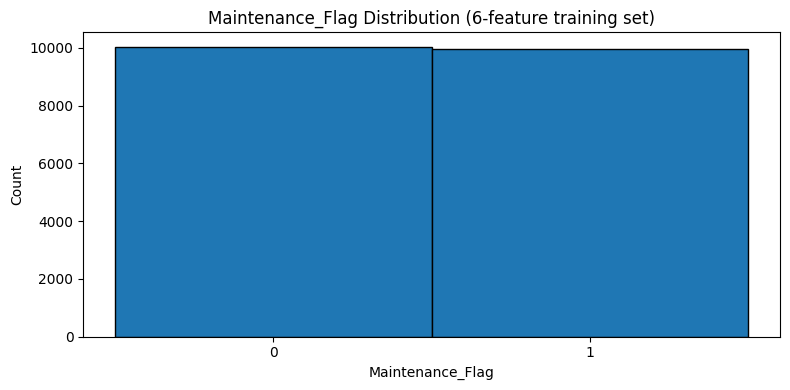

In [92]:
target_vals = df_model.select(target_column).to_series().to_numpy()
plt.figure(figsize=(8, 4))
plt.hist(target_vals, bins=[-0.5, 0.5, 1.5], edgecolor="black")
plt.title("Maintenance_Flag Distribution (6-feature training set)")
plt.xlabel(target_column)
plt.ylabel("Count")
plt.xticks([0, 1])
plt.tight_layout()
plt.show()

## 7) Save Artifacts and Re-run Pipeline

In [93]:
def save_artifacts(model, feature_columns):
    MODEL_DIR.mkdir(parents=True, exist_ok=True)
    model.booster_.save_model(str(MODEL_OUTPUT)) if hasattr(model, 'booster_') else model.save_model(str(MODEL_OUTPUT))
    with FEATURES_OUTPUT.open("w", encoding="utf-8") as f:
        json.dump(feature_columns, f, indent=2)
    print("Saved:")
    print("-", MODEL_OUTPUT)
    print("-", FEATURES_OUTPUT)


In [94]:
# Train the model and save it (standard workflow)
# Assumes train_model and save_artifacts are defined in previous cells

# Train the model
model, _, _ = train_model(df_model, feature_columns, target_column, random_state=RANDOM_STATE)

# Save the trained model and feature columns
save_artifacts(model, feature_columns)


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 6950, number of negative: 7050
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000430 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 14000, number of used features: 6
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.496429 -> initscore=-0.014286
[LightGBM] [Info] Start training from score -0.014286


/var/folders/3r/q4143glx4k7774nqyy23sp540000gn/T/ipykernel_86850/2039849458.py:19: DeprecationWarning: `is_in` with a collection of the same datatype is ambiguous and deprecated.
Please use `implode` to return to previous behavior.

See https://github.com/pola-rs/polars/issues/22149 for more information.
  train_split = train_df.filter(pl.col("_rn").is_in(pl.Series(list(idx_train))))
/var/folders/3r/q4143glx4k7774nqyy23sp540000gn/T/ipykernel_86850/2039849458.py:20: DeprecationWarning: `is_in` with a collection of the same datatype is ambiguous and deprecated.
Please use `implode` to return to previous behavior.

See https://github.com/pola-rs/polars/issues/22149 for more information.
  val_split = train_df.filter(pl.col("_rn").is_in(pl.Series(list(idx_val))))
/var/folders/3r/q4143glx4k7774nqyy23sp540000gn/T/ipykernel_86850/2039849458.py:21: DeprecationWarning: `is_in` with a collection of the same datatype is ambiguous and deprecated.
Please use `implode` to return to previous behavior

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
Validation Metrics:
Accuracy: 0.5163
ROC-AUC: 0.5106
PR-AUC: 0.5182
Precision: 0.5364
Recall: 0.1880
F1: 0.2785
Saved:
- /Users/polisetty/Downloads/projects/Minimal Predictive Agent/app/models/sensor_lgbm_model.txt
- /Users/polisetty/Downloads/projects/Minimal Predictive Agent/app/models/sensor_feature_columns.json
